In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

In [ ]:
stock_data = yf.download('DJI', start='2018-01-01', end='2023-03-18')
prices = stock_data[['Close']]
print(prices.head())

[*********************100%***********************]  1 of 1 completed
                   Close
Date                    
2018-01-02  24824.000000
2018-01-03  24922.699219
2018-01-04  25075.099609
2018-01-05  25295.900391
2018-01-08  25283.000000


In [ ]:
len(stock_data)

877

In [ ]:
print(stock_data.head())

                    Open          High           Low         Close  \
Date                                                                 
2018-01-02  24824.000000  24824.000000  24824.000000  24824.000000   
2018-01-03  24922.699219  24922.699219  24922.699219  24922.699219   
2018-01-04  25075.099609  25075.099609  25075.099609  25075.099609   
2018-01-05  25295.900391  25295.900391  25295.900391  25295.900391   
2018-01-08  25283.000000  25283.000000  25283.000000  25283.000000   

               Adj Close     Volume  
Date                                 
2018-01-02  24824.000000  285673487  
2018-01-03  24922.699219  421035113  
2018-01-04  25075.099609  361273375  
2018-01-05  25295.900391  305122391  
2018-01-08  25283.000000  278355041  


In [ ]:
stock_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,877.000000,877.000000,877.000000,877.000000,877.000000,8.770000e+02
mean,28507.538350,28531.138585,28480.634701,28506.898669,28506.898669,1.017292e+08
std,4279.319987,4259.132278,4302.719525,4279.520727,4279.520727,1.497483e+08
min,18591.900391,18591.900391,18591.900391,18591.900391,18591.900391,0.000000e+00
25%,25142.800781,25196.800781,25064.400391,25128.199219,25128.199219,0.000000e+00
50%,26597.000000,26616.699219,26554.400391,26584.800781,26584.800781,0.000000e+00
75%,33131.800781,33131.800781,33131.800781,33131.800781,33131.800781,2.378127e+08
max,36799.699219,36799.699219,36799.699219,36799.699219,36799.699219,7.582325e+08


In [ ]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 877 entries, 2018-01-02 to 2022-03-02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       877 non-null    float64
 1   High       877 non-null    float64
 2   Low        877 non-null    float64
 3   Close      877 non-null    float64
 4   Adj Close  877 non-null    float64
 5   Volume     877 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 48.0 KB


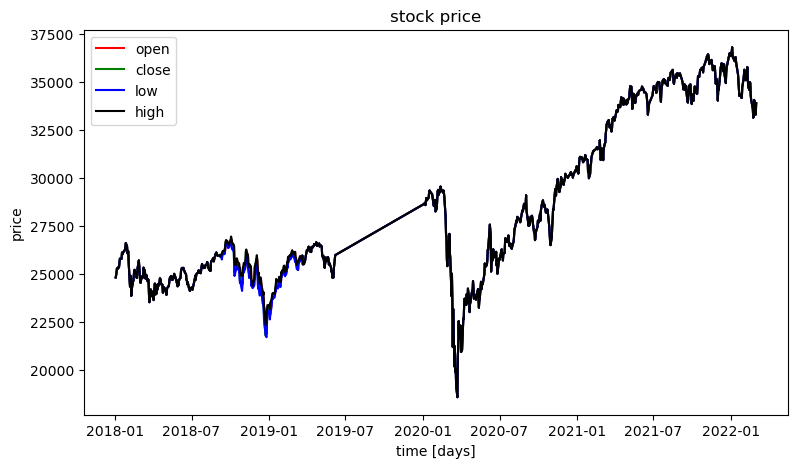

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(stock_data["Open"],color="red",label="open")
plt.plot(stock_data["Close"],color="green",label="close")
plt.plot(stock_data["Low"],color="blue",label="low")
plt.plot(stock_data["High"],color="black",label="high")
plt.title("stock price")
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')

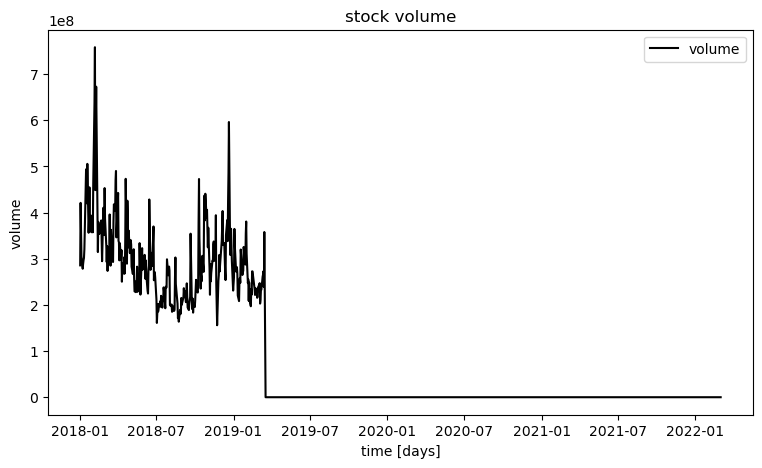

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(stock_data["Volume"],color="black",label="volume")
plt.title("stock volume")
plt.xlabel("time [days]")
plt.ylabel("volume")
plt.legend(loc="best")

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
prices['Close'] = scaler.fit_transform(prices['Close'].values.reshape(-1,1))

In [ ]:
def label_up_down(row):
    if row['Close'] > row['Lag1']:
        return 1 # up
    else:
        return 0 # down

def create_df_close_lag(ticker, lag=10, start_date='2010-01-01', end_date='2022-03-02'):
    tickerDF = ticker.copy()

    ## add lag columns
    col_name_lst = []
    for i in range(lag):
        col_name = 'Lag'+str(i+1)
        col_name_lst.append(col_name)
        tickerDF[col_name] = tickerDF['Close'].shift(i+1)
    #print(tickerDF)
    col_name_lst.append('Close')
    tickerDF_lag = tickerDF[col_name_lst]
    #print(tickerDF_lag)
    ## add label
    tickerDF_lag['Label'] = tickerDF_lag.apply(label_up_down, axis=1)
    print(tickerDF_lag)
    ## add control variables (^DJI)
    tickerDataDJI = yf.Ticker('^DJI')
    #print(tickerDataDJI)
    tickerDFDJI = tickerDataDJI.history(period='1d', start=start_date, end=end_date)
    tickerDFDJI['DJI_Lag1'] = tickerDFDJI['Close'].shift(1)
    tickerDF_lag.index = tickerDF_lag.index.tz_localize(tickerDFDJI.index.tz)
    res = pd.merge(tickerDF_lag, tickerDFDJI['DJI_Lag1'], left_index=True, right_index=True)

    res = res.dropna()
    res = res.drop('Close', axis=1)
    res = res.reindex(columns=col_name_lst[:-1]+['DJI_Lag1', 'Label'])

    return res

In [ ]:
df2=create_df_close_lag(prices)

                Lag1      Lag2      Lag3      Lag4      Lag5      Lag6  \
Date                                                                     
2018-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
2018-01-03 -0.315447       NaN       NaN       NaN       NaN       NaN   
2018-01-04 -0.304606 -0.315447       NaN       NaN       NaN       NaN   
2018-01-05 -0.287866 -0.304606 -0.315447       NaN       NaN       NaN   
2018-01-08 -0.263612 -0.287866 -0.304606 -0.315447       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-02-24  0.597107  0.648162  0.701172  0.726744  0.795099  0.801085   
2022-02-25  0.607212  0.597107  0.648162  0.701172  0.726744  0.795099   
2022-02-28  0.698931  0.607212  0.597107  0.648162  0.701172  0.726744   
2022-03-01  0.680676  0.698931  0.607212  0.597107  0.648162  0.701172   
2022-03-02  0.615022  0.680676  0.698931  0.607212  0.597107  0.648162   

                Lag7      Lag8      L

In [ ]:
df2["Date"]=df2.index

In [ ]:
df1=df2[["Date","Lag1","Lag2","Lag3","Lag4","Lag5","Lag6","Lag7","Lag8","Lag9","Lag10"]]

In [ ]:
df1

,Date,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,Lag10
Date,,,,,,,,,,,
2018-01-17 00:00:00-05:00,2018-01-17 00:00:00-05:00,-0.209020,-0.207889,-0.232988,-0.255572,-0.253737,-0.265029,-0.263612,-0.287866,-0.304606,-0.315447
2018-01-18 00:00:00-05:00,2018-01-18 00:00:00-05:00,-0.173563,-0.209020,-0.207889,-0.232988,-0.255572,-0.253737,-0.265029,-0.263612,-0.287866,-0.304606
2018-01-19 00:00:00-05:00,2018-01-19 00:00:00-05:00,-0.184317,-0.173563,-0.209020,-0.207889,-0.232988,-0.255572,-0.253737,-0.265029,-0.263612,-0.287866
2018-01-22 00:00:00-05:00,2018-01-22 00:00:00-05:00,-0.178396,-0.184317,-0.173563,-0.209020,-0.207889,-0.232988,-0.255572,-0.253737,-0.265029,-0.263612
2018-01-23 00:00:00-05:00,2018-01-23 00:00:00-05:00,-0.162700,-0.178396,-0.184317,-0.173563,-0.209020,-0.207889,-0.232988,-0.255572,-0.253737,-0.265029
...,...,...,...,...,...,...,...,...,...,...,...
2022-02-23 00:00:00-05:00,2022-02-23 00:00:00-05:00,0.648162,0.701172,0.726744,0.795099,0.801085,0.754666,0.773548,0.828854,0.886686,0.853151
2022-02-24 00:00:00-05:00,2022-02-24 00:00:00-05:00,0.597107,0.648162,0.701172,0.726744,0.795099,0.801085,0.754666,0.773548,0.828854,0.886686
2022-02-25 00:00:00-05:00,2022-02-25 00:00:00-05:00,0.607212,0.597107,0.648162,0.701172,0.726744,0.795099,0.801085,0.754666,0.773548,0.828854


In [ ]:
x_train = df1.loc[:'2022-01-01 00:00:00-05:00',"Lag1":"Lag10"]
y_train = df1.loc[:'2022-01-01 00:00:00-05:00',"Lag10"]
x_test = df1.loc['2022-01-01 00:00:00-05:00':,"Lag1":"Lag10"]
y_test = df1.loc['2022-01-01 00:00:00-05:00':,"Lag10"]

In [ ]:
#lag=10

In [ ]:
train_inputs = torch.Tensor(np.array(x_train))
train_targets = torch.Tensor(np.array(y_train))
test_inputs = torch.Tensor(np.array(x_test))
test_targets = torch.Tensor(np.array(y_test))

In [ ]:
train_targets.shape

torch.Size([826])

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_dim).requires_grad_()
        #print(h0.shape)
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:,:]) 
        return out

In [ ]:
input_dim = 10
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

In [ ]:
def train(model, train_inputs, train_targets, num_epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(train_inputs)
        loss = criterion(outputs, train_targets)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        print('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    return train_losses

In [ ]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
learning_rate=0.01

In [ ]:
train_gru=train(model, train_inputs, train_targets, num_epochs, learning_rate)

Epoch [1/10], Train Loss: 0.2411
Epoch [2/10], Train Loss: 0.2029
Epoch [3/10], Train Loss: 0.2141
Epoch [4/10], Train Loss: 0.2069
Epoch [5/10], Train Loss: 0.1992
Epoch [6/10], Train Loss: 0.1992
Epoch [7/10], Train Loss: 0.2016
Epoch [8/10], Train Loss: 0.2026
Epoch [9/10], Train Loss: 0.2017
Epoch [10/10], Train Loss: 0.2001


In [ ]:
def evaluate(model, test_inputs, test_targets, scaler):
    model.eval()
    test_loss=0
    with torch.no_grad():
        outputs = model(test_inputs)
        loss = criterion(outputs, test_targets)
    print(loss.item())
    return test_targets, outputs

In [ ]:
eva_gru=evaluate(model, test_inputs, test_targets, scaler)

0.6881744265556335


In [ ]:
eva_gru[0]

tensor([0.9009, 0.8425, 0.7949, 0.8564, 0.8851, 0.9454, 0.9559, 0.9658, 0.9559,
        0.9493, 0.9764, 1.0000, 0.9569, 0.9381, 0.9376, 0.9197, 0.9398, 0.9440,
        0.9246, 0.9025, 0.8428, 0.8055, 0.7711, 0.7216, 0.7325, 0.7252, 0.7109,
        0.7101, 0.7722, 0.8168, 0.8468, 0.8714, 0.8145, 0.8122, 0.8123, 0.8532,
        0.8867, 0.8289, 0.7735, 0.7547])

In [ ]:
target=eva_gru[0].reshape(1,-1).tolist()

In [ ]:
predict=eva_gru[1].reshape(1,-1).tolist()

In [ ]:
test_targets

tensor([0.9009, 0.8425, 0.7949, 0.8564, 0.8851, 0.9454, 0.9559, 0.9658, 0.9559,
        0.9493, 0.9764, 1.0000, 0.9569, 0.9381, 0.9376, 0.9197, 0.9398, 0.9440,
        0.9246, 0.9025, 0.8428, 0.8055, 0.7711, 0.7216, 0.7325, 0.7252, 0.7109,
        0.7101, 0.7722, 0.8168, 0.8468, 0.8714, 0.8145, 0.8122, 0.8123, 0.8532,
        0.8867, 0.8289, 0.7735, 0.7547])

In [ ]:
testScore = math.sqrt(mean_squared_error(eva_gru[0],eva_gru[1]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.83 RMSE
